In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture as GM
from sklearn.metrics import rand_score

In [2]:
np.set_printoptions(suppress=True)

<h2>0.1. Предварительная обработка данных</h2>

In [3]:
X = pd.read_excel('X_4_13.xlsx', header=None)

Y = pd.read_excel('Y_4_13.xlsx', header=None)

X

,0,1,2,3
0,5.092168,1.034724,7.080165,-1.987996
1,4.846424,0.968371,6.787735,-1.941311
2,5.297292,1.205368,6.978480,-1.681188
3,3.729736,0.846779,4.919136,-1.189400
4,5.003340,1.094723,6.722511,-1.719171
...,...,...,...,...
195,3.674291,0.826147,4.870143,-1.195852
196,3.711996,0.911068,4.690788,-0.978792
197,4.504129,0.705877,6.890626,-2.386497
198,4.891603,0.973449,6.862858,-1.971255


In [4]:
X.describe()

,0,1,2,3
count,200.000000,200.000000,200.000000,200.000000
mean,2.999880,0.978973,3.062841,-0.062961
std,2.665400,1.190919,2.636290,1.659201
min,-1.770611,-1.098890,-1.686545,-3.001601
25%,0.967169,0.094967,1.037855,-1.337723
50%,3.043348,1.013192,3.001980,-0.003096
75%,5.053307,1.939336,5.064147,1.147939
max,7.684823,3.085918,8.097899,3.110166


In [5]:
X.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

<AxesSubplot:>

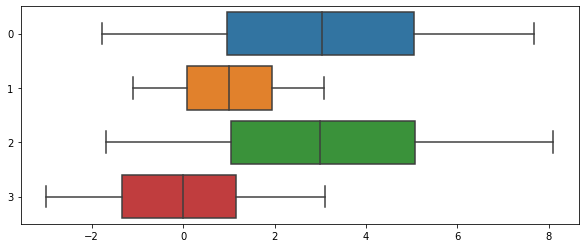

In [6]:
plt.figure(figsize=(10,4))
sns.boxplot(data=X, orient='h')

In [7]:
Y

,0,1,2,3
0,0.906940,1.006914,0.963778,0.824834
1,2.029085,0.799312,1.623610,0.952911
2,1.978421,1.102946,1.458704,0.978444
3,2.275134,0.829438,1.964464,1.040498
4,1.276684,0.056152,-0.198731,1.130742
...,...,...,...,...
195,2.011200,0.939179,1.924253,0.916095
196,2.166127,1.092028,1.849896,1.069608
197,1.004772,0.952281,0.960462,0.711798
198,1.894961,0.872430,1.811809,1.079972


In [8]:
Y.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

<AxesSubplot:>

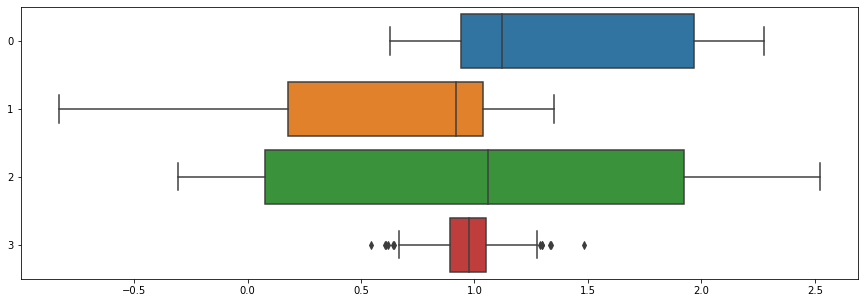

In [9]:
plt.figure(figsize=(15,5))
sns.boxplot(data=Y, orient='h')

Стандартизируем данные, используя z-оценку:

In [10]:
X_st = pd.DataFrame(zscore(X))
Y_st = pd.DataFrame(zscore(Y))

Чтобы сделать предварительные выводы о количестве и видах кластеров, а также выбрать подходящий алгоритм кластеризации, визуализируем данные, предварительно уменьшив их размерность до n=2. Чтобы понять, насколько будет велика погрешность в этом случае, выполним SVD-разложение и рассчитаем ошибку аппроксимации:

In [11]:
def count_approx_error(S):
    ev_table = pd.DataFrame()

    pc_num = [i+1 for i in range(len(S))]
    
    ev_table[0] = pc_num
    
    ev_table[1] = S.round(2)
    
    qrS = S ** 2
    
    ev_table[2] = qrS.round(2)
   
    percentvar = [round(i/sum(qrS)*100,2) for i in S**2]
    
    ev_table[3] = percentvar
    
    ev_table[4] = np.cumsum(percentvar)

    ev_table.columns=['Главные факторы', 'Сингулярные значения',
                                    'Собственные значения', 'Вклад в вариацию(%)',
                                    'Кумулятивный вклад в вариацию(%)']
    return ev_table

In [12]:
Ux, Sx, VTx = np.linalg.svd(X_st)
count_approx_error(Sx)

,Главные факторы,Сингулярные значения,Собственные значения,Вклад в вариацию(%),Кумулятивный вклад в вариацию(%)
0,1,22.83,521.26,65.16,65.16
1,2,16.70,278.74,34.84,100.00
2,3,0.00,0.00,0.00,100.00
3,4,0.00,0.00,0.00,100.00


In [13]:
Uy, Sy, VTy = np.linalg.svd(Y_st)
count_approx_error(Sy)

,Главные факторы,Сингулярные значения,Собственные значения,Вклад в вариацию(%),Кумулятивный вклад в вариацию(%)
0,1,22.11,488.90,61.11,61.11
1,2,14.20,201.64,25.20,86.31
2,3,9.92,98.34,12.29,98.60
3,4,3.33,11.12,1.39,99.99


В случае с датасетом X первые 2 признака сохраняют 100% информации. В случае с датасетом Y при n = 2 ошибка  составляет 13.69%, что достаточно мало для того, чтобы ориентироваться на такую аппроксимацию.

Теперь визуализируем данные: построим карты объектов для X и для Y.

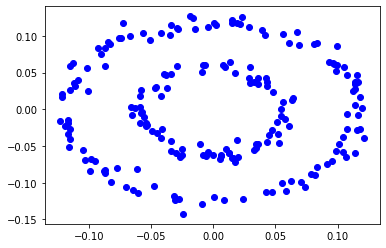

In [14]:
X_2d = Ux[:,:2]
plt.plot(X_2d[:,0], X_2d[:,1],'bo')

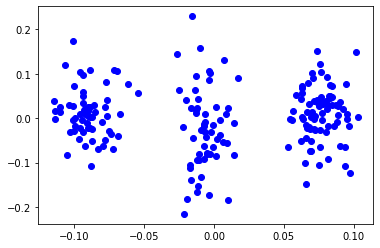

In [15]:
Y_2d = Uy[:,:2]
plt.plot(Y_2d[:,0], Y_2d[:,1],'bo')

В датасете Y мы видим 3 четко сформированных кластера примерно одинакового размера, для каждого из которых можно найти центр. Предположительно любой алгоритм, использующий центры кластеров, даст соответствующий результат.

Датасет X представляет собой 2 концентрических кластера, не имеющих центра. Вероятно, стандартные алгоритмы не смогут выполнить кластеризацию правильным образом.

<h2>0.2. Подготовка данных</h2>

In [129]:
from sklearn.manifold import MDS

In [130]:
metrics = ('mahalanobis', 'correlation', 'minkowski', 'euclidean')

dist_m_x = {}

dist_m_y = {}

for metric in metrics:
    
    dist_m_x[metric] = pdist(X_st, metric, p=1)
    
    dist_m_y[metric] = pdist(Y_st, metric, p=1)
    
dist_m_x = pd.DataFrame(dist_m_x)
dist_m_y = pd.DataFrame(dist_m_y)

Корреляции между расстояниями:

In [131]:
dist_m_x.corr('kendall')

,mahalanobis,correlation,minkowski,euclidean
mahalanobis,1.000000,0.539039,0.779450,0.813653
correlation,0.539039,1.000000,0.431137,0.460070
minkowski,0.779450,0.431137,1.000000,0.947866
euclidean,0.813653,0.460070,0.947866,1.000000


In [132]:
dist_m_y.corr('kendall')

,mahalanobis,correlation,minkowski,euclidean
mahalanobis,1.000000,0.388785,0.538976,0.577128
correlation,0.388785,1.000000,0.426155,0.434227
minkowski,0.538976,0.426155,1.000000,0.889614
euclidean,0.577128,0.434227,0.889614,1.000000


Выберем расстояние следующим образом: на основе матрицы расстояний проведем многомерное шкалирование и визуализируем результаты. Мы предполагаем, что метрика расстояния подойдет для решения данной задачи, если полученные на ее основе 2-мерные векторы образуют то же количество кластеров с примерно тем же количеством элементов в каждом из них.

In [133]:
def perform_mds(dist_m):
    
    for distance_matrix in dist_m:
        
        print('Метрика: {}'.format(distance_matrix))
        
        tmp_new = embedding.fit_transform(squareform(dist_m[distance_matrix]))
        
        plt.plot(tmp_new[:,0], tmp_new[:,1],'bo')
        
        plt.show()

MDS для датасета X:

Метрика: mahalanobis


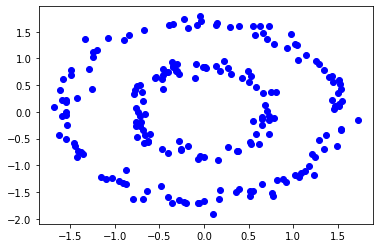

Метрика: correlation


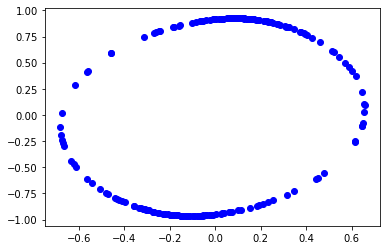

Метрика: minkowski


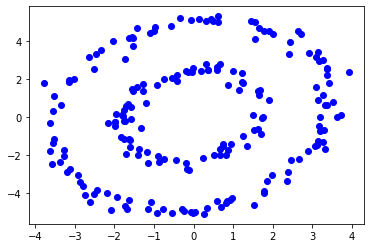

Метрика: euclidean


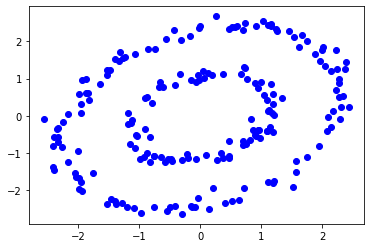

In [134]:
embedding = MDS(n_components=2, dissimilarity = 'precomputed', eps=1e-6)

perform_mds(dist_m_x)

Датасет Y:

Метрика: mahalanobis


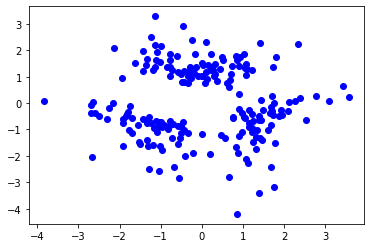

Метрика: correlation


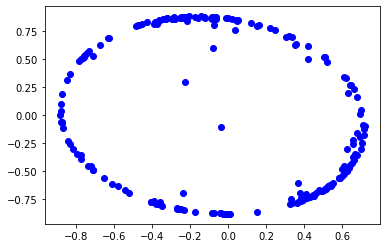

Метрика: minkowski


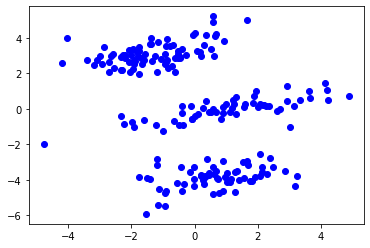

Метрика: euclidean


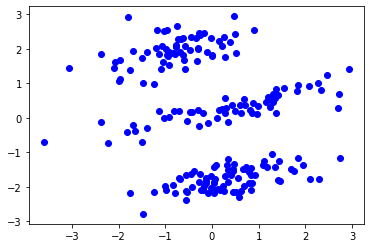

In [135]:
perform_mds(dist_m_y)

Видно, что структура кластеров сохраняется для всех расстояний, кроме корреляции, но точнее всего повторяют карту объектов векторы, полученные на основе евклидова расстояния. Его и будем использовать для кластеризации.

Получим матрицу близости на основе матрицы расстояний и построим графовую модель для каждого датасета:

In [16]:
def similarity_to_graph(sim_mat):
    n = sim_mat.shape[0]
    G = nx.Graph()
    _ = [G.add_node(i for i in range(n))]
    for i in range(len(sim_mat)-1):
        for j in range(i+1,len(sim_mat)):
            w = sim_mat[i][j]
            G.add_edge(i, j, weight=w)
        
    G.remove_node(list(G.nodes)[0])
    return G

In [17]:
X_dis = squareform(pdist(X_st, 'euclidean'))
similarity_X = np.exp(-X_dis**2*7)
X_graph = similarity_to_graph(similarity_X)

In [18]:
Y_dis = squareform(pdist(Y_st, 'euclidean'))
similarity_Y = np.exp(-Y_dis**2*1/4)
Y_graph = similarity_to_graph(similarity_Y)

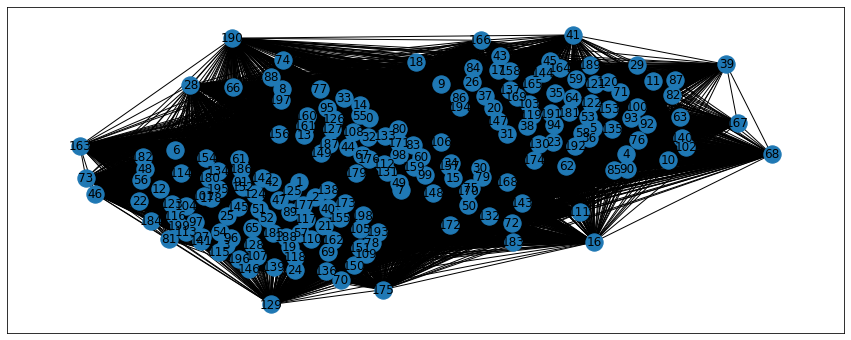

In [19]:
plt.figure(figsize=(15, 6))
pos=nx.spring_layout(Y_graph)
nx.draw_networkx(Y_graph,pos)

## Кластеризация

### 1. Кластеризация для числа кластеров k=2.

In [20]:
def perform_clustering(sim_matrix, dataset, n = 2):

    clusters = {}

    #single linkage
    
    clusters['single linkage'] = AgglomerativeClustering(n_clusters=n, 
                                                         linkage='single').fit_predict(sim_matrix)
    
    #EM-algo
    
    em = GM(n_components=n, covariance_type='full',  tol = 1e-06)
    
    clusters['EM-algorithm'] = em.fit_predict(dataset)
    
    #k-means 
    
    clusters['k-means'] = KMeans(n_clusters=n, random_state=32).fit_predict(dataset)
    
    #spectral
    
    clusters['spectral'] = SpectralClustering(n_clusters=n,
                                affinity ='precomputed',
                                random_state=32).fit_predict(sim_matrix)
    
    return pd.DataFrame(clusters)

def get_rindex_matrix(clusters, num_of_algos = 4):
    
    """Возвращает матрицу RAND индексов для каждой пары делений на кластеры
    clusters - pd. DataFrame - кластеры, полученные разными алгоритмами
    num_of_algos - количество примененных алгоритмов"""
    
    rand_index = lambda i,j: rand_score(clusters[clusters.columns[i]], clusters[clusters.columns[j]])
    
    rand_X = np.array([rand_index(i,j) for i in range(num_of_algos) for j in range(num_of_algos)]).reshape(4,4)

    return pd.DataFrame(rand_X, index = clusters_X.columns, columns = clusters_X.columns)

In [23]:
clusters_X = perform_clustering(similarity_X, X_st)
rindex_X = get_rindex_matrix(clusters_X)

clusters_Y = perform_clustering(similarity_Y, Y_st)
rindex_Y = get_rindex_matrix(clusters_Y)

In [24]:
rindex_X

,single linkage,EM-algorithm,k-means,spectral
single linkage,1.000000,0.500704,0.497688,1.000000
EM-algorithm,0.500704,1.000000,0.772663,0.500704
k-means,0.497688,0.772663,1.000000,0.497688
spectral,1.000000,0.500704,0.497688,1.000000


In [25]:
rindex_Y

,single linkage,EM-algorithm,k-means,spectral
single linkage,1.000000,0.586131,1.000000,0.586131
EM-algorithm,0.586131,1.000000,0.586131,1.000000
k-means,1.000000,0.586131,1.000000,0.586131
spectral,0.586131,1.000000,0.586131,1.000000


In [26]:
def get_modularity_for_2(G, clusters):
    cluster1 = []
    cluster2 = []
    cluster_labels = np.array(clusters).tolist()
    for id, e in enumerate(cluster_labels):
        if e == 0:
            cluster1.append(id)
        else:
            cluster2.append(id)
    similarity_communities = [set(cluster1), set(cluster2)]
    modularity = nx.algorithms.community.quality.modularity(X_graph, similarity_communities)
    return modularity

def print_modularity_2():
    print("Модулярность для набора данных X:")
    print("single linkage:", get_modularity_for_2(X_graph, clusters_X['single linkage']))
    print("EM-algorithm:", get_modularity_for_2(X_graph, clusters_X['EM-algorithm']))
    print("k-means:", get_modularity_for_2(X_graph, clusters_X['k-means']))
    print("spectral:", get_modularity_for_2(X_graph, clusters_X['spectral']))
    print()
    print("Модулярность для набора данных Y:")
    print("single linkage:", get_modularity_for_2(Y_graph, clusters_Y['single linkage']))
    print("EM-algorithm:", get_modularity_for_2(Y_graph, clusters_Y['EM-algorithm']))
    print("k-means:", get_modularity_for_2(Y_graph, clusters_Y['k-means']))
    print("spectral:", get_modularity_for_2(Y_graph, clusters_Y['spectral']))

In [27]:
print_modularity_2()

Модулярность для набора данных X:
single linkage: 0.49881899021544374
EM-algorithm: 0.46435404018999205
k-means: 0.45137389659840865
spectral: 0.49881899021544374

Модулярность для набора данных Y:
single linkage: -0.014898764171593665
EM-algorithm: 0.009094489509806805
k-means: -0.014898764171593665
spectral: 0.009094489509806805


### K-means

In [28]:
color_map = ['darkred', 'steelblue', 'darkseagreen']
def plot_clusters(algo, clst):
    
    data = X_2d if clst == 'X' else Y_2d
    
    clusters = clusters_X if clst == 'X' else clusters_Y
    
    for i in range(200):
        
        plt.scatter(data[:,0][i] , data[:,1][i], color=color_map[clusters[algo][i]])

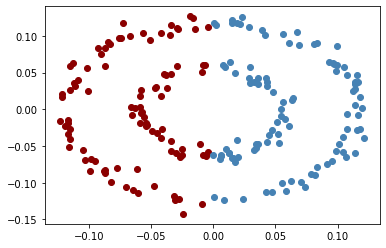

In [29]:
plot_clusters('k-means', 'X')

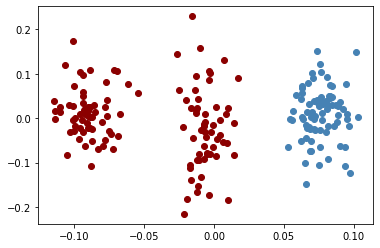

In [30]:
plot_clusters('k-means', "Y")

### SpectralClustering

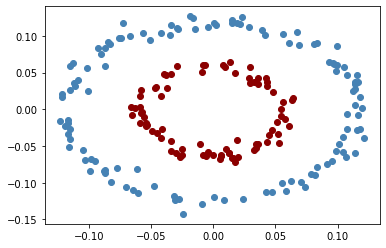

In [31]:
plot_clusters('spectral', "X")

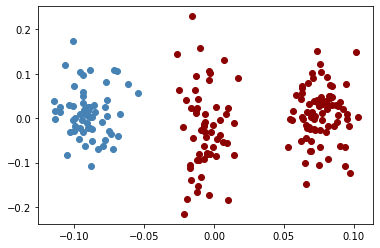

In [32]:
plot_clusters('spectral', "Y")

### EM-algorithm

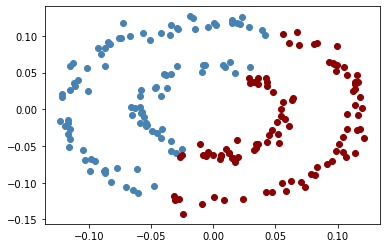

In [33]:
plot_clusters('EM-algorithm', "X")

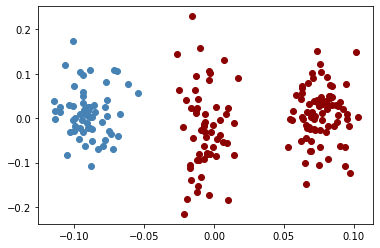

In [34]:
plot_clusters('EM-algorithm', "Y")

### Single linkage

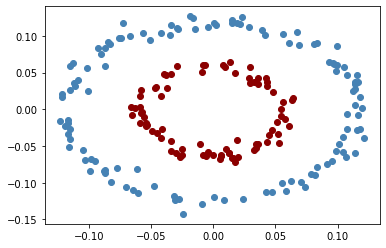

In [35]:
plot_clusters('single linkage', "X")

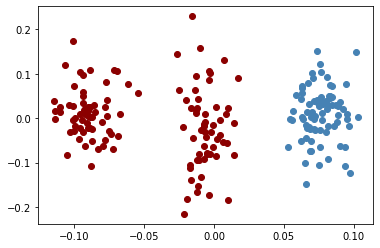

In [36]:
plot_clusters('single linkage', "Y")

### 2. Кластеризация для числа кластеров k=3.

In [37]:
clusters_X = perform_clustering(similarity_X, X_st, 3)
rindex_X = get_rindex_matrix(clusters_X)

clusters_Y = perform_clustering(similarity_Y, Y_st, 3)
rindex_Y = get_rindex_matrix(clusters_Y)

In [38]:
rindex_X

,single linkage,EM-algorithm,k-means,spectral
single linkage,1.000000,0.560754,0.542412,0.748744
EM-algorithm,0.560754,1.000000,0.666382,0.603467
k-means,0.542412,0.666382,1.000000,0.673568
spectral,0.748744,0.603467,0.673568,1.000000


In [39]:
rindex_Y

,single linkage,EM-algorithm,k-means,spectral
single linkage,1.0,1.0,1.0,1.0
EM-algorithm,1.0,1.0,1.0,1.0
k-means,1.0,1.0,1.0,1.0
spectral,1.0,1.0,1.0,1.0


### K-means

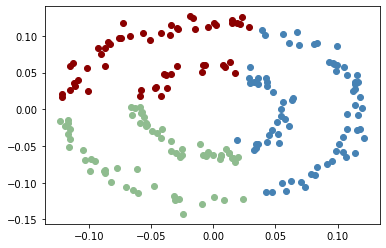

In [40]:
plot_clusters('k-means', 'X')

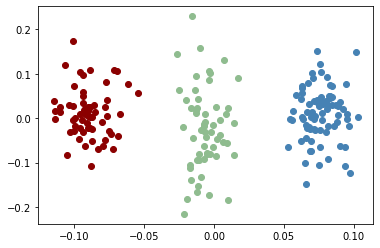

In [41]:
plot_clusters('k-means', 'Y')

### SpectralClustering

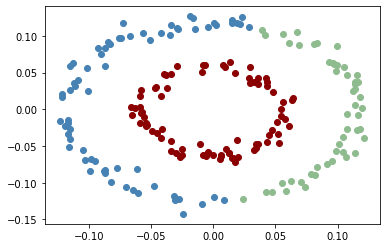

In [42]:
plot_clusters('spectral', 'X')

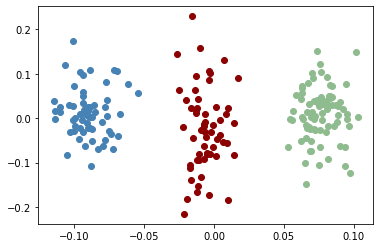

In [44]:
plot_clusters('spectral', 'Y')

### EM-algorithm

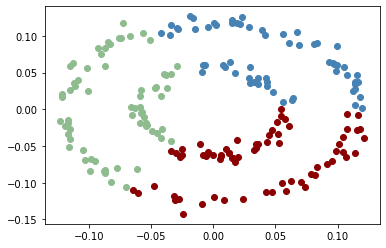

In [45]:
plot_clusters('EM-algorithm', "X")

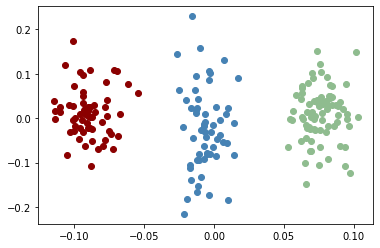

In [46]:
plot_clusters('EM-algorithm', "Y")

### Single linkage

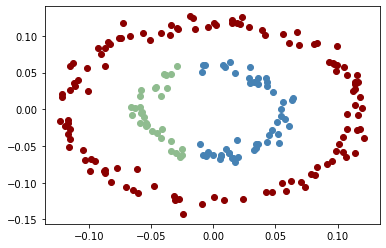

In [47]:
plot_clusters('single linkage', "X")

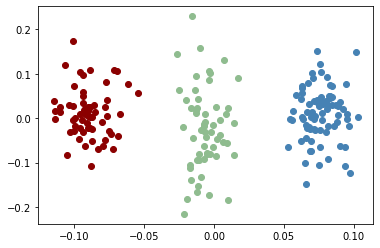

In [48]:
plot_clusters('single linkage', "Y")

In [49]:
def get_modularity_for_3(G, clusters):
    cluster1 = []
    cluster2 = []
    cluster3 = []
    cluster_labels = np.array(clusters).tolist()
    for id, e in enumerate(cluster_labels):
        if e == 0:
            cluster1.append(id)
        elif e == 1:
            cluster2.append(id)
        else:
            cluster3.append(id)
    similarity_communities = [set(cluster1), set(cluster2), set(cluster2)]
    modularity = nx.algorithms.community.quality.modularity(X_graph, similarity_communities)
    return modularity

In [50]:
def get_modularity_for_3(G, clusters):
    cluster1 = []
    cluster2 = []
    cluster3 = []
    cluster_labels = np.array(clusters).tolist()
    for id, e in enumerate(cluster_labels):
        if e == 0:
            cluster1.append(id)
        elif e == 1:
            cluster2.append(id)
        else:
            cluster3.append(id)
    similarity_communities = [set(cluster1), set(cluster2), set(cluster3)]
    modularity = nx.algorithms.community.quality.modularity(X_graph, similarity_communities)
    return modularity

def print_modularity_3():
    print("Модулярность для набора данных X:")
    print("single linkage:", get_modularity_for_3(X_graph, clusters_X['single linkage']))
    print("EM-algorithm:", get_modularity_for_3(X_graph, clusters_X['EM-algorithm']))
    print("k-means:", get_modularity_for_3(X_graph, clusters_X['k-means']))
    print("spectral:", get_modularity_for_3(X_graph, clusters_X['spectral']))
    print()
    print("Модулярность для набора данных Y:")
    print("single linkage:", get_modularity_for_3(Y_graph, clusters_Y['single linkage']))
    print("EM-algorithm:", get_modularity_for_3(Y_graph, clusters_Y['EM-algorithm']))
    print("k-means:", get_modularity_for_3(Y_graph, clusters_Y['k-means']))
    print("spectral:", get_modularity_for_3(Y_graph, clusters_Y['spectral']))

In [51]:
print_modularity_3()

Модулярность для набора данных X:
single linkage: 0.607751619044649
EM-algorithm: 0.6208938142937039
k-means: 0.6027161246692463
spectral: 0.6121725721686015

Модулярность для набора данных Y:
single linkage: -0.004565184716943865
EM-algorithm: -0.004565184716943865
k-means: -0.004565184716943865
spectral: -0.004565184716943865
